In [1]:
import pandas as pd
import numpy as np
from os import mkdir
from os.path import isdir
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import savgol_filter
from os import listdir
from collections import OrderedDict

import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [2]:
with open("../data/clariostar/legend.csv", "w") as csv_legend:
    with open("../data/clariostar/legend.tsf", "r") as legendfile:
        for line in legendfile.readlines():
            line = line.rstrip().split(" ")
            text = line[0] + ","
            csv_legend.write(text)
            for index, element in enumerate(line):

                if index != 0:
                    if element != "":
    
                        if index+1 != len(line):
                            element = element + " " 
                            csv_legend.write(element)
                        else:
                            csv_legend.write(element + "\n")

In [3]:
legend = pd.read_csv("../data/clariostar/legend.csv")

In [4]:
legend_dict = {}
for media in legend["M_Number"]:
    legend_dict[media] = legend[legend["M_Number"] == media]["BMM9 variant"].item()

In [5]:
legend_dict["Duganella_0"] = "Duganella"
legend_dict["Undibacterium_0"] = "Undibacterium"
legend_dict["Acidovorax_0"] = "Acidovorax"
legend_dict["CVULGARIS_0"] = "C. vulgaris"
legend_dict["CDSMZ_0"] = "C. DSMZ"
legend_dict["Pelomonas_0"] = "Pelomonas"
legend_dict["AEP_0"] = "Curvibacter sp. AEP1-3"
legend_dict["AEP_1"] = "Curvibacter sp. AEP1-3"
legend_dict["AEP_2"] = "Curvibacter sp. AEP1-3"
legend_dict["vul_0"] = "C. vulgaris"
legend_dict["vul_1"] = "C. vulgaris"
legend_dict["vul_2"] = "C. vulgaris"
legend_dict["vir_0"] = "C. viridissima"
legend_dict["vir_1"] = "C. viridissima"
legend_dict["car_0"] = "C. carnea"
legend_dict["car_1"] = "C. carnea"
legend_dict["oli_0"] = "C. oligactis"
legend_dict["oli_1"] = "C. oligactis"

In [6]:
'''read_clariostar_table

    Function for reading a csv file.

    :param dataframe_path
        :type str
    :param separator
        :type str
    :param lines_to_skip
        :type int

'''
def read_clariostar_table(dataframe_path:str,separator:str,lines_to_skip:int)->pd.DataFrame:
    try:
        return pd.read_csv(dataframe_path,sep=separator,skiprows=lines_to_skip)
    except Exception as e:
        raise Exception("[-] ERROR reading dataframe with exception: {}".format(e))

In [7]:
'''read_layout

    This function reads the layout dataframe and returns a dictionary with
    content information for each well and a dictionary with media and blank association.
    
'''
def read_layout(layout:pd.DataFrame)->tuple:
    try:
        layout_dict = {}
        blank_vals = []
        media_vals = []
        for index in layout.index:
            for row_index, media_name in enumerate(layout.loc[index,:]):
                layout_row = index + "0" + str(row_index+1)
                content = media_name
                layout_dict[layout_row] = media_name

                if "M" in media_name and media_name not in media_vals:
                    media_vals.append(media_name)
                elif "_" in media_name and media_name not in media_vals:
                    media_vals.append(media_name)
                elif "B" in media_name and media_name not in blank_vals:
                    blank_vals.append(media_name)

        media_blank_dict = {}
        for media in media_vals:
            if "_" not in media:
                media_number = int(media.split("M")[-1])
            else:
                media_number = int(media.split("_")[-1])
            for blank in blank_vals:
                blank_number = int(blank.split("B")[-1])
                if media_number == blank_number:
                    media_blank_dict[media] = blank
                    break
            if media not in list(media_blank_dict.keys()):
                raise Exception("[-] ERROR there is no blank for media: {}".format(media))
        return layout_dict, media_blank_dict
    except Exception as e:
        raise Exception("[-] ERROR during creation of layout_dict with exception: {}".format(e))

In [8]:
'''transpose_dataframe
    
    This function can be used to transpose a ClarioStar dataframe.
    
    :param dataframe
        :type pd.DataFrame
        
    :returns dataframe
        :type pd.DataFrame
        
'''
def transpose_dataframe(dataframe:pd.DataFrame)->pd.DataFrame:
    try:
        dataframe = dataframe.copy()
        #dataframe.append(dataframe.columns.to_series(), ignore_index=True)
        dataframe.loc[len(dataframe)] = dataframe.columns.to_list()
        tDataframe = dataframe.T
        tDataframe = tDataframe.reset_index()
        tDataframe.columns = tDataframe.iloc[0,:]
        tDataframe = tDataframe.drop(0, axis=0)
        tDataframe = tDataframe.reset_index()
        tDataframe = tDataframe.drop("index", axis=1)
        tDataframe = tDataframe.loc[:, ~tDataframe.columns.duplicated()]
        tDataframe["Well"] = tDataframe["Well"].apply(lambda x: x.split(".")[0])
        return tDataframe
    except Exception as e:
        raise Exception("[-] ERROR transposing the dataframe with exception: {}".format(e))

In [9]:
'''create_od_gfp_dataframes

    This function takes the raw dataframe and the layout_dict dictionary to 
    create new columns that can be used to assess the data for OD600 and GFP.
    This data is within the rows: "Raw Data (600 1)" and "Raw Data (470-15 2)".
    The function also calculates BLANK values for each experimental unit and 
    finally produces blank corrected datasets for each experiment, which are 
    returned in form of dictionaries.
    
'''
def create_od_gfp_dataframes(dataframe:pd.DataFrame,layout_dict:dict,blank_dict:dict)->tuple:
    try:
        print("[*] Creating OD/GFP dataframe dictionaries")
        data = dataframe.copy()

        # get row index of content, group and well rows
        content_index = data.index[data.iloc[:,0] == "Content"].to_list()
        group_index = data.index[data.iloc[:,0] == "Group"].to_list()
        well_index = data.index[data.iloc[:,0] == "Well"].to_list()
        if len(content_index) != 1:
            raise Exception("[-] There are multiple Content indexes in the dataframe!")
        if len(group_index) != 1:
            raise Exception("[-] There are multiple Group indexes in the dataframe!")
        if len(well_index) != 1:
            raise Exception("[-] There are multiple Well indexes in the dataframe!")

        # rename columns based on well row and layout dict
        print(well_index)
        new_columns = []
        for col in data.loc[:,:].columns:
            well_value = data[col].loc[well_index[0]]
            if well_value in list(layout_dict.keys()):
                new_col = layout_dict[well_value]
            else:
                new_col = col
            new_columns.append(new_col)
        print("[*] Setting up new columns")
        data.columns = new_columns

        # get OD and GFP data
        od_data = data[data["Unnamed: 0"] == "Raw Data (600 1)"]
        
        if len(od_data) == 0:
            od_data = data[data["Unnamed: 0"] == "Raw Data (600)"]
        
        gfp_data = data[data["Unnamed: 0"] == 'Raw Data (470-15 2)']

        # get a list of unique media entries
        print("[*] Creating list of unique experiments")
        media_entries = []
        for key in layout_dict.keys():
            media = layout_dict[key]
            if "M" in media:
                if media not in media_entries:
                    media_entries.append(media)
            elif "_" in media:
                if media not in media_entries:
                    media_entries.append(media)

        # loop over each media data and create blank corrected dataframes
        od_dict = {}
        gfp_dict = {}
        print("[*] Looping over unique media entries (experiments)")
        for media in media_entries:
            blank = blank_dict[media]
            blank_data_od = od_data[blank].astype(float)
            blank_data_gfp = gfp_data[blank].astype(float)
            
            media_data_od = od_data[media].astype(float)
            media_data_gfp = gfp_data[media].astype(float)
            
            # calculate BLANK values as mean values
            if type(blank_data_gfp) == pd.Series:
                blank_od = blank_data_od[:50].mean()
                blank_gfp = blank_data_gfp[:50].mean()
            else:
                blank_od = blank_data_od.mean(axis=1)[:50].mean()
                blank_gfp = blank_data_gfp.mean(axis=1)[:50].mean()

            print("\t[*] BLANK value OD600 for media {} is {}".format(media, blank_od))
            print("\t[*] BLANK value GFP is {}".format(blank_gfp))
            media_data_od_blank_corrected = media_data_od - blank_od
            media_data_gfp_blank_corrected = media_data_gfp - blank_gfp

            media_data_od_blank_corrected.index = list(range(1,media_data_od_blank_corrected.index.size+1,1))
            media_data_gfp_blank_corrected.index = list(range(1,media_data_gfp_blank_corrected.index.size+1,1))
            
            od_dict[media] = media_data_od_blank_corrected
            gfp_dict[media] = media_data_gfp_blank_corrected
            
        return od_dict, gfp_dict
    except Exception as e:
        raise Exception("[-] ERROR creating od/gfp dataframe with exception: {}".format(e))

In [10]:
'''plot_od_gfp

    This function takes the od_dict and gfp_dict produced by the 
    create_od_gfp_dataframes function and creates basic overview plots.
    The save path is composed of the media and date value.

'''
def plot_od_gfp(od_data_dict:dict,gfp_data_dict:dict,date:str)->int:
    try:
        print("[*] Saving plots in ../results/figures/clariostar/{}/*".format(date))
        savep = "../results/figures/clariostar/{}/".format(date)
        if isdir(savep) == False:
            print("\t[*] Directory does not yet exist, creating directory: {}".format(savep))
            mkdir(savep)
            
        print("[*] Looping over keys and plotting data ...")
        for media in od_data_dict.keys():
            od_data = od_data_dict[media]
            gfp_data = gfp_data_dict[media]

            if od_data.empty != True:
                time = (od_data.index.to_numpy() * 10)/60
                time = time.round(2)
                x_index = od_data.index.to_numpy()
                time = time[::40]
                x_index = x_index[::40]
    
                mean_od_values = od_data.mean(axis=1)
                mean_std_values = od_data.std(axis=1)
                x_index_mean = od_data.index.to_numpy()
                
                plt.figure(figsize=(8,6))
                plt.plot(od_data, color="blue",alpha=0.5)
                plt.errorbar(x_index_mean[::40],
                             mean_od_values[::40],
                             yerr=mean_std_values[::40],
                             ecolor="red",capsize=5, color="red")
                plt.xticks(x_index,time)
                plt.title(media + ": " + legend_dict[media], fontsize=10)
                plt.xlabel("time in hours [h]")
                plt.ylabel("blank corrected OD600")
                plt.ylim(-0.2,3.0)
                plt.grid()
                plot_path = savep + media + "_od_data.svg"
                plt.savefig(plot_path,dpi=300)
                plt.close()
            else:
                print("\t[WARNING] There is no OD data available for {}".format(media))
            if gfp_data.empty != True:
                time = (gfp_data.index.to_numpy() * 10)/60
                time = time.round(2)
                x_index = gfp_data.index.to_numpy()
                time = time[::40]
                x_index = x_index[::40]
                
                plt.figure(figsize=(8,6))
                plt.plot(gfp_data, color="green")
                plt.xticks(x_index,time)
                plt.title(media + ": " + legend_dict[media], fontsize=10)
                plt.xlabel("time in hours [h]")
                plt.ylabel("blank corrected GFP RFU")
                plt.grid()
                plot_path = savep + media + "_gfp_data.svg"
                plt.savefig(plot_path,dpi=300)
                plt.close()
            else:
                print("\t[WARNING] There is no GFP data available for {}".format(media))

        print("[+] DONE")
        return 1
    except Exception as e:
        raise Exception("[-] ERROR creating basic OD/GFP plots with exception: {}".format(e))

In [11]:
def apply_savgol_filter_on_data_dict(data_dict:dict)->dict:
    try:
        print("[+] Trying to apply savgol filter to dataframe ...")
        filtered_dict = {}
        for key in data_dict.keys():

            od_data_columns = data_dict[key].columns
            new_cols = list(range(len(od_data_columns)))
            data_dict[key].columns = new_cols
            
            temp_dict = {}
            for col in data_dict[key].columns:
                temp_dict[col] = savgol_filter(data_dict[key][col],50,1)
            
            temp_df = pd.DataFrame(temp_dict)
            print("\t[*] Adjusting Index DataFrame: {}".format(key))
            temp_df.index = np.array(range(1,len(data_dict[key][col]) + 1))*10
            print("\t[*] Replacing NaN values with -2.0")
            #temp_df = temp_df.fillna(-2.0)
            temp_df.columns = od_data_columns
            filtered_dict[key] = temp_df

        print("[+] DONE")
        return filtered_dict
    except Exception as e:
        raise Exception("[-] ERROR during savgol filter applying with exception: {}".format(e))

In [12]:
def transform_od_data_dict(od_data:dict)->dict:
    try:
        print("[+] Starting to transform OD data dictionary")


        for key in od_data.keys():
            print("\t[*] Working with: {}".format(key))
        
            od_data_columns = od_data[key].columns
            new_cols = list(range(len(od_data_columns)))
            od_data[key].columns = new_cols
            
            new_data_dict = {}
            for col in od_data[key].columns:
                # od_data[key][col] = od_data[key][col].apply(lambda x: 0.0 if )
                new_data_column = od_data[key][col] - min(od_data[key][col])
                new_data_dict[col] = new_data_column
            od_data[key] = pd.DataFrame(new_data_dict)
            od_data[key].columns = od_data_columns

            
        print("[+] DONE")
        return od_data
    except Exception as e:
        raise Exception("[-] ERROR during transformation of od_data with exception: {}".format(e))

In [13]:
def calculate_log_regression(data_dict:dict, steps=50)->tuple:
    try:
        print("[+] Starting plotting procedure with slope extension ...")
        lineregress_dict = {}
        slope_dict = {}
        for key in data_dict.keys():
            print("\t[*] Working with sample: {}".format(key))
            mean_arr = data_dict[key].mean(axis=1).to_numpy()
            x_arr = np.array(range(1,len(mean_arr)+1)) * 10
            #mean_value_dict[key] = mean_arr
            
            lineregress_dict[key] = {}
            slope_dict[key] = {}
            for column in data_dict[key].columns:
                
                data_column = data_dict[key][column].to_numpy()
                
                start = 0
                temp_end = steps
                end = 1200
                step = steps

                results_lineregress = []
                slope_entries = []
                print("\t[*] Collecting slope data for each: {} steps".format(step))
                while(start < end):
                    sliced_arr_y = data_column[start:temp_end]
                    sliced_arr_x = x_arr[start:temp_end]
                    if len(sliced_arr_y) != 0:
                        res = stats.linregress(x=sliced_arr_x,y=sliced_arr_y)

                        results_lineregress.append((start, temp_end, res.slope, res.intercept))
                        slope_entries.append(res.slope)
                    start += step
                    temp_end += step

                lineregress_dict[key][column] = results_lineregress
                slope_dict[key][column] = slope_entries
        return lineregress_dict, slope_dict
    except Exception as e:
        raise Exception("[-] ERROR with exception: {}".format(e))

In [14]:
def transform_data_dict_to_log10(data_dict:dict)->dict:
    try:
        print("[+] Trying to transform dataframe ...")
        log_data_dict = {}
        
        for key in data_dict.keys():
            log_data_dict[key] = np.log10(data_dict[key])
            log_data_dict[key] = log_data_dict[key].apply(lambda col: col.fillna(col.min()))

        print("[+] DONE")
        return log_data_dict
    except Exception as e:
        raise Exception("[-] ERROR during data transformation with exception: {}".format(e))

In [15]:
def calculate_generation_times(log_data_dict:dict,start_od=0.3, end_od=0.4)->pd.DataFrame:
    try:
        print("[+] Starting to calculate generation times ...")
        generation_time_dict = {}
        
        for key in log_data_dict.keys():
            
            generation_time_dict[key] = []
            
            old_cols = log_data_dict[key].columns
            new_cols = list(range(len(old_cols)))
            log_data_dict[key].columns = new_cols
            
            for col in log_data_dict[key].columns:
                end_index = -500
                start_index = -500
                switch_0 = False
                switch_1 = False
                for index, value in enumerate(log_data_dict[key][col]):
                    if value >= np.log10(start_od) and switch_0 == False:
                        start_val = value
                        start_index = index
                        switch_0 = True
                    if value >= np.log10(end_od) and switch_1 == False:
                        end_val = value
                        end_index = index
                        switch_1 = True
                if end_index == -500 or start_index == -500:
                    generation_time = 0.0
                else:
                    slope_time = (end_index - start_index) * 10
                    n = ((end_val - start_val)/np.log10(2))
                    generation_time = slope_time / n
                generation_time_dict[key].append(generation_time)
            log_data_dict[key].columns = old_cols
            #print(generation_time_dict)
        
        generation_time_df = pd.DataFrame.from_dict(generation_time_dict, orient='index').transpose()

        print("[+] DONE")
        return generation_time_df
    except Exception as e:
        raise Exception("[-] ERROR calculating generation times with exception: {}".format(e))

In [16]:
def plot_generation_time(generation_time_data:pd.DataFrame, date:str, filename:str)->int:
    try:
        print("[+] Plotting generation time boxplots for {}".format(date))
        savep = "../results/figures/clariostar/{}/{}".format(date, filename)
        box_props = dict(color="black", linewidth=2)
        median_props = dict(color="red")
        whisker_props = dict(color="black")
        
        ax = gtime_data.boxplot(grid=False, boxprops=box_props, medianprops=median_props, whiskerprops=whisker_props)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.ylim(0,10)
        plt.savefig(savep, dpi=300)
        plt.close()
        print("[+] DONE")
        return 1
    except Exception as e:
        raise Exception("[-] ERROR creating generation time boxplots with exception: {}".format(e))

In [17]:
def plot_max_od(max_od_dataframe:pd.DataFrame, date:str, filename:str)->int:
    try:
        print("[+] Plotting maximum OD boxplots for {}".format(date))
        savep = "../results/figures/clariostar/{}/{}".format(date, filename)
        box_props = dict(color="black", linewidth=2)
        median_props = dict(color="red")
        whisker_props = dict(color="black")
        
        ax = max_od_dataframe.boxplot(grid=False, boxprops=box_props, medianprops=median_props, whiskerprops=whisker_props)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.ylim(0,3.0)
        plt.savefig(savep, dpi=300)
        plt.close()
        print("[+] DONE")
        return 1
    except Exception as e:
        raise Exception("[-] ERROR creating maximum OD boxplots with exception: {}".format(e))

In [18]:
'''plot_log_data

    Plotting logarithmic data into savep.

'''
def plot_log_data(log_dict:dict, date:str)->int:
    try:
        savep = "../results/figures/clariostar/{}/".format(date)
        for key in log_dict.keys():
            print("[*] Plotting log data for: {}".format(key))
            log_data = log_data_dict[key]
            
            time = (log_data.index.to_numpy() * 10)/60
            time = time.round(2)
            x_index = log_data.index.to_numpy()
            time = time[::40]
            x_index = x_index[::40]
            
            mean_od_values = log_data.mean(axis=1)
            mean_std_values = log_data.std(axis=1)
            x_index_mean = log_data.index.to_numpy()
            
            plt.figure(figsize=(8,6))
            plt.plot(log_data, color="blue",alpha=0.5)
            plt.errorbar(x_index_mean[::40],
                         mean_od_values[::40],
                         yerr=mean_std_values[::40],
                         ecolor="red",capsize=5, color="red")
            plt.xticks(x_index,time)
            plt.title(key + ": " + legend_dict[key], fontsize=10)
            plt.xlabel("time in hours [h]")
            plt.ylabel("blank corrected log2(OD600)")
            plt.ylim(-2.2,1.0)
            plt.grid()
            plot_path = savep + key + "_log_data.svg"
            plt.savefig(plot_path,dpi=300)
            plt.close()
        return 1
    except Exception as e:
        raise Exception("[-] ERROR with exception: {}".format(e))
            

In [19]:
data_path = "../data/clariostar/data_files/"
data_layout_dict = {}
dates = []
for date in listdir(data_path):
    date = date.split("_clariostar_")[0]
    if date not in dates:
        dates.append(date)
        data_layout_dict[date] = (data_path + date+"_clariostar_data.CSV", data_path + date + "_clariostar_layout.csv")

In [20]:
not_to_use_experiments = ["24_02_05",
                          "24_03_07_l1",
                          "24_03_07_l2","24_04_08","24_04_18"]

not_to_use_experiments_dict = {"24_03_14_l1":["M6"],
                               "24_03_14_l2":["M6"],
                               "24_03_21":["M2","M15"],
                               "24_04_02":["M24"],
                               "24_04_08":["M33","M35"],"24_04_05_l2":["M28"]}

all_od_data_dict = {}
all_gfp_data_dict = {}
all_gtime_data_dict = {}
summary_gtime_data = {}

for date in data_layout_dict:

    if date not in not_to_use_experiments:
        
        print("[*] WORKING ON DATE: {}".format(date))
        path_to_data = data_layout_dict[date][0]
        path_to_layout = data_layout_dict[date][1]
        
        data = read_clariostar_table(path_to_data,separator=";",lines_to_skip=5)
        data = data.replace(",",".", regex=True)
        
        # fix for duganella undibacterium acidovorax dsmz c. vulgaris dataframe
        if date == "24_11_22_l2" or date == "24_11_29_l2":
            data = transpose_dataframe(data)
            
        if date == "24_05_17" or date == "24_11_22_l1" or date == "24_11_22_l2" or date == "24_11_29_l1" or date == "24_11_29_l2":
            new_row = data.columns
            new_cols = ["Unnamed: {}".format(x) for x in range(len(data.columns))]
            data.columns = range(len(data.columns))
            data = pd.concat([pd.DataFrame([new_row]), data])
            data.columns = new_cols
            data = data.reset_index(drop=True)

        
        layout = pd.read_csv(path_to_layout, sep=";", index_col=0)
        
        layout_dict, media_blank_dict = read_layout(layout)
        # break
        od_dict, gfp_dict = create_od_gfp_dataframes(data,layout_dict,media_blank_dict)

        if date in list(not_to_use_experiments_dict.keys()):
            for media in not_to_use_experiments_dict[date]:
                print("[*] Removing: {} from {}".format(media,date))
                del od_dict[media]
                del gfp_dict[media]
            
        # restricting time to 66h
        for key in od_dict.keys():
            if date != "24_03_25_l1":
                od_dict[key] = od_dict[key].iloc[:460,:]
                gfp_dict[key] = gfp_dict[key].iloc[:460,:]

                
        
        # plot_od_gfp(od_dict, gfp_dict, date)
        all_od_data_dict[date] = od_dict
        all_gfp_data_dict[date] = gfp_dict
        
        od_data = transform_od_data_dict(all_od_data_dict[date])
        od_data = apply_savgol_filter_on_data_dict(od_data)
        log_data_dict = transform_data_dict_to_log10(od_data)

        # plot_log_data(log_data_dict,date)
        
        #gtime = calculate_generation_times(log_data_dict, start_od=0.05, end_od=0.1)
        #gtime_data = np.round(gtime/60, 2)
        #plot_generation_time(gtime_data, date, "generation_time_005_01.svg")
    
        gtime = calculate_generation_times(log_data_dict, start_od=0.1, end_od=0.4)
        gtime_data = np.round(gtime/60, 2)
        #plot_generation_time(gtime_data, date, "generation_time_01_04.svg")
    
        for col in gtime_data.columns:
            if col not in list(summary_gtime_data.keys()):
                summary_gtime_data[col] = gtime_data[col].to_list()
            else:
                for val in gtime_data[col]:
                    summary_gtime_data[col].append(val)
        
        all_gtime_data_dict[date] = gtime_data
    
        max_od_dict = {}
        for media in od_dict.keys():
            max_values = od_dict[media].max()
            # max_std = max_values.std()
            max_od_dict[media] = max_values
        
        max_od_dataframe = pd.DataFrame.from_dict(max_od_dict)
        # plot_max_od(max_od_dataframe,date,"max_od.svg")

[*] WORKING ON DATE: 24_02_02
[*] Creating OD/GFP dataframe dictionaries
[0]
[*] Setting up new columns
[*] Creating list of unique experiments
[*] Looping over unique media entries (experiments)
	[*] BLANK value OD600 for media M1 is 0.15159
	[*] BLANK value GFP is 1296.0
	[*] BLANK value OD600 for media M2 is 0.13072
	[*] BLANK value GFP is 1474.61
	[*] BLANK value OD600 for media M3 is 0.1323
	[*] BLANK value GFP is 1302.68
	[*] BLANK value OD600 for media M4 is 0.15354000000000004
	[*] BLANK value GFP is 1092.32
	[*] BLANK value OD600 for media M5 is 0.14190000000000003
	[*] BLANK value GFP is 1176.18
[+] Starting to transform OD data dictionary
	[*] Working with: M1
	[*] Working with: M2
	[*] Working with: M3
	[*] Working with: M4
	[*] Working with: M5
[+] DONE
[+] Trying to apply savgol filter to dataframe ...
	[*] Adjusting Index DataFrame: M1
	[*] Replacing NaN values with -2.0
	[*] Adjusting Index DataFrame: M2
	[*] Replacing NaN values with -2.0
	[*] Adjusting Index DataFrame

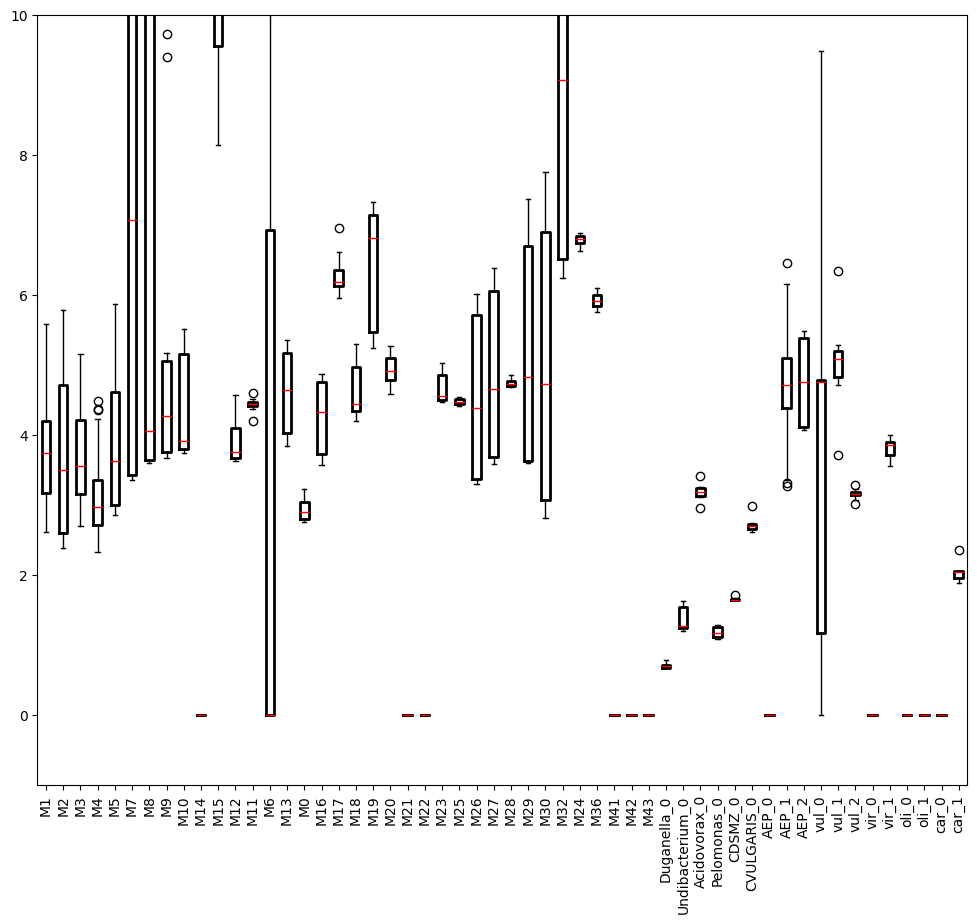

In [21]:
labels = list(summary_gtime_data.keys())
values = list(summary_gtime_data.values())

box_props = dict(color="black", linewidth=2)
median_props = dict(color="red")
whisker_props = dict(color="black")

boxplot_values = []
for vallist in values:
    boxplot_values.append([x for x in vallist if np.isnan(x) == False])

plt.figure(figsize=(12,10))
boxplot= plt.boxplot(boxplot_values, labels=labels, manage_ticks=True, 
                     boxprops=box_props, medianprops=median_props, whiskerprops=whisker_props)

xticks = plt.xticks(rotation=90)
plt.ylim(-1,10)
plt.show()

In [22]:
sorted_medium = {}
medium_legend_table = pd.read_csv("../data/clariostar/legend.csv")

for medium, description in zip(medium_legend_table["M_Number"], medium_legend_table["BMM9 variant"]):
    if medium in list(summary_gtime_data.keys()):
        sorted_medium[medium] = []
        for amino_acid in description.split(";"):
            sorted_medium[medium].append(amino_acid.strip())

del sorted_medium["M0"]

In [23]:
sorted_medium_dict = OrderedDict(sorted(sorted_medium.items(), key=lambda item: len(item[1])))

In [24]:
m = len(sorted_medium_dict.keys())

index = sorted_medium_dict["M2"]
numpy_matrix = np.zeros((len(index), m))

for column,key in enumerate(sorted_medium_dict.keys()):
    #print(column,key)
    for row, amino_acid in enumerate(index):
        if amino_acid in sorted_medium_dict[key]:
            numpy_matrix[row,column] = 1
            #print("[+] Found {} in {}".format(amino_acid,key))
        else:
            numpy_matrix[row,column] = 0

In [25]:
df = pd.DataFrame(numpy_matrix)
df.index = index
df.columns = list(sorted_medium_dict.keys())
df

,M15,M21,M22,M23,M41,M42,M43,M7,M9,M10,...,M1,M6,M11,M12,M24,M25,M26,M27,M28,M2
Aspartat,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Asparagin,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
Isoleucin,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
Threonin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
Tryptophan,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
Phenylalanin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
Methionin,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Histidin,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Arginin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0


In [32]:
df = df.loc[:, (df.sum() >= 8) | (df.sum() == 1) | (df.sum() == 0)]
df = df[["M2","M1","M26","M12","M27","M24","M25","M6","M11","M28","M43","M41","M22","M42","M23","M21","M15"]]

In [33]:
data_dict = {}
for col in df.columns:
    if col == "M15":
        # take daa for the "washed" experiment
        data_dict[col] = summary_gtime_data["AEP_0"][12:]
    else:
        data_dict[col] = summary_gtime_data[col][:6]
    #print(len(summary_gtime_data[col]))

In [34]:
for key in data_dict.keys():
    new_vals = []
    for val in data_dict[key]:
        if np.isnan(val) == False:
            #if val < 10:
            #    new_vals.append(val)
            #else:
            #    new_vals.append(0.0)
            new_vals.append(val)
    data_dict[key] = new_vals

In [38]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

df = pd.DataFrame([(key, val) for key, values in data_dict.items() for val in values], columns=["Group", "Value"])
df.head()

,Group,Value
0,M2,5.79
1,M2,5.02
2,M2,5.04
3,M2,5.48
4,M2,5.03


In [42]:
rel_keys = []
for key, values in data_dict.items():
    if key != "M2":  # Compare each key against M2
        anova_result = stats.f_oneway(data_dict["M2"], values[:6])
        if anova_result.pvalue <= 0.05:
            print(f"ANOVA {key} vs M2 p-value:", anova_result.pvalue)
            rel_keys.append(key)
            
# If ANOVA is significant for at least one group, perform Tukey's HSD test
all_groups = []
all_values = []

for key, values in data_dict.items():
    if key == "M2" or key in data_dict:  # Only include M2 and tested groups
        all_groups.extend([key] * len(values[:6]))
        all_values.extend(values[:6])

# Convert to DataFrame for Tukey's HSD test
df_tukey = pd.DataFrame({"Group": all_groups, "Value": all_values})

# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(df_tukey["Value"], df_tukey["Group"])
print(tukey_result)

ANOVA M12 vs M2 p-value: 6.404236633722061e-06
ANOVA M24 vs M2 p-value: 6.882047302194667e-05
ANOVA M25 vs M2 p-value: 0.012047780888353832
ANOVA M6 vs M2 p-value: 3.2389911436282414e-11
ANOVA M11 vs M2 p-value: 0.0019186127523283087
ANOVA M43 vs M2 p-value: 8.243870277719522e-09
ANOVA M41 vs M2 p-value: 8.243870277719522e-09
ANOVA M22 vs M2 p-value: 3.2389911436282414e-11
ANOVA M42 vs M2 p-value: 8.243870277719522e-09
ANOVA M23 vs M2 p-value: 0.003576141926527282
ANOVA M21 vs M2 p-value: 3.2389911436282414e-11
ANOVA M15 vs M2 p-value: 3.2389911436282414e-11
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    M1    M11  -0.2133    1.0 -1.1578  0.7311  False
    M1    M12   -0.975  0.036 -1.9194 -0.0306   True
    M1    M15  -4.6683    0.0 -5.6128 -3.7239   True
    M1     M2   0.4933 0.8977 -0.4511  1.4378  False
    M1    M21  -4.6683    0.0 -5.6128 -3.7239   True
    M1    M

In [36]:
for key in data_dict.keys():
    result = stats.mannwhitneyu(data_dict["M2"], data_dict[key])
    if result.pvalue <= 0.05:
        print(key, result.pvalue, result.statistic)
    else:
        print(key)

M2
M1
M26
M12 0.004998124765082457 36.0
M27
M24 0.009523809523809525 0.0
M25 0.009523809523809525 24.0
M6 0.00277843011009903 36.0
M11 0.0021645021645021645 36.0
M28
M43 0.011417221487911723 24.0
M41 0.011417221487911723 24.0
M22 0.00277843011009903 36.0
M42 0.011417221487911723 24.0
M23 0.00812704263106845 35.0
M21 0.00277843011009903 36.0
M15 7.48574411268451e-05 72.0


In [30]:
data_dict.keys()

dict_keys(['M2', 'M1', 'M26', 'M12', 'M27', 'M24', 'M25', 'M6', 'M11', 'M28', 'M43', 'M41', 'M22', 'M42', 'M23', 'M21', 'M15'])

In [31]:
list(data_dict.values())

[[5.79, 5.02, 5.04, 5.48, 5.03, 4.61],
 [4.9, 4.53, 3.9, 5.59, 4.85, 4.24],
 [3.3, 3.34, 3.38, 3.43, 5.35, 5.69],
 [3.81, 3.76, 3.67, 3.66, 3.63, 3.63],
 [3.58, 3.68, 3.67, 3.72, 5.6, 6.02],
 [6.82, 6.63, 6.77, 6.88],
 [4.42, 4.54, 4.45, 4.5],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [4.41, 4.52, 4.42, 4.45, 4.44, 4.49],
 [4.74, 4.85, 4.69, 4.71],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [4.5, 4.53, 4.49, 4.47, 4.5, 4.62],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

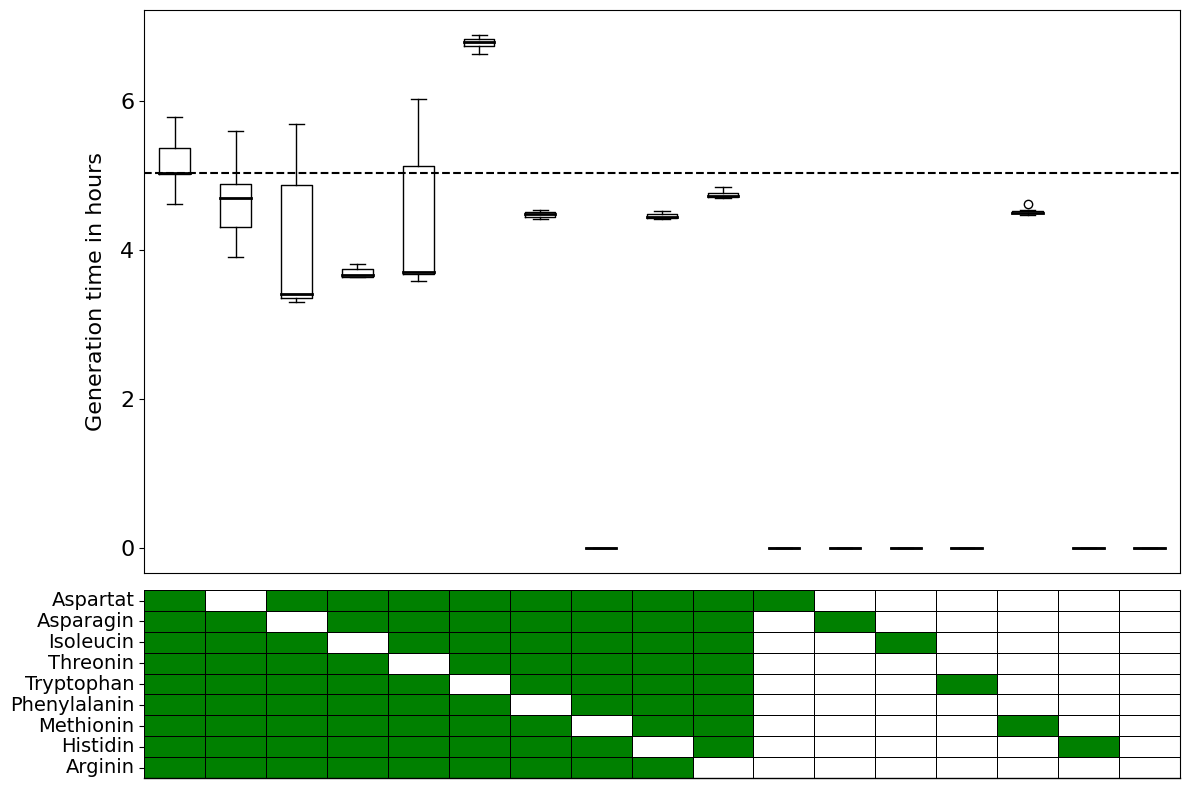

In [34]:
xticks = [x+0.5 for x in range(len(data_dict.keys()))]
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 1, height_ratios=[3, 1])  # Boxplot above (1) and heatmap below (3)

ax1 = fig.add_subplot(gs[0])
boxplot_data = list(data_dict.values())

box = ax1.boxplot(boxplot_data, positions=xticks)
for median in box['medians']:
    median.set(color='black', linewidth=2)  # Change median color to red
    
ax1.set_title("")
ax1.set_xlabel("")
ax1.set_ylabel("Generation time in hours", fontsize=16, labelpad=10)
ax1.set_yticks(ticks=[0,2,4,6,8,10], labels=[0,2,4,6,8,10], fontsize=16)
ax1.tick_params(axis="x", which="both", bottom=False, labelbottom=False) 
ax1.hlines(np.median(data_dict["M2"]), xmin=0, xmax=44, color="black", linestyle="--")
# ax1.grid()
ax2 = fig.add_subplot(gs[1], sharex=ax1)
colormap = ListedColormap(['white', 'green'])
sns.heatmap(df, cmap=colormap, cbar=False, linewidths=0.5, annot=False, ax=ax2, linecolor="black")
ax2.tick_params(axis="x", which="both", bottom=False, labelbottom=False) 
ax2.spines['bottom'].set_visible(True)
ax2.spines['right'].set_visible(True) # Make sure the bottom spine (x-axis) is visible
ax2.tick_params(axis="y", labelsize=14)
# Optionally, you can adjust the line color and width if desired
ax2.spines['bottom'].set_linewidth(1)
ax2.spines['bottom'].set_color('black')
# Adjust layout and display
plt.tight_layout()
plt.savefig("../results/figures/clariostar/amino_acids_combined_gtimes.svg", dpi=300)

In [33]:
max_od_per_media = {}
for date in all_od_data_dict.keys():
    for media in all_od_data_dict[date].keys():
        if media not in list(max_od_per_media.keys()):
            max_od_per_media[media] = all_od_data_dict[date][media].max(axis=0).to_list()
        else:
            for entry in all_od_data_dict[date][media].max(axis=0).to_list():
                max_od_per_media[media].append(entry)

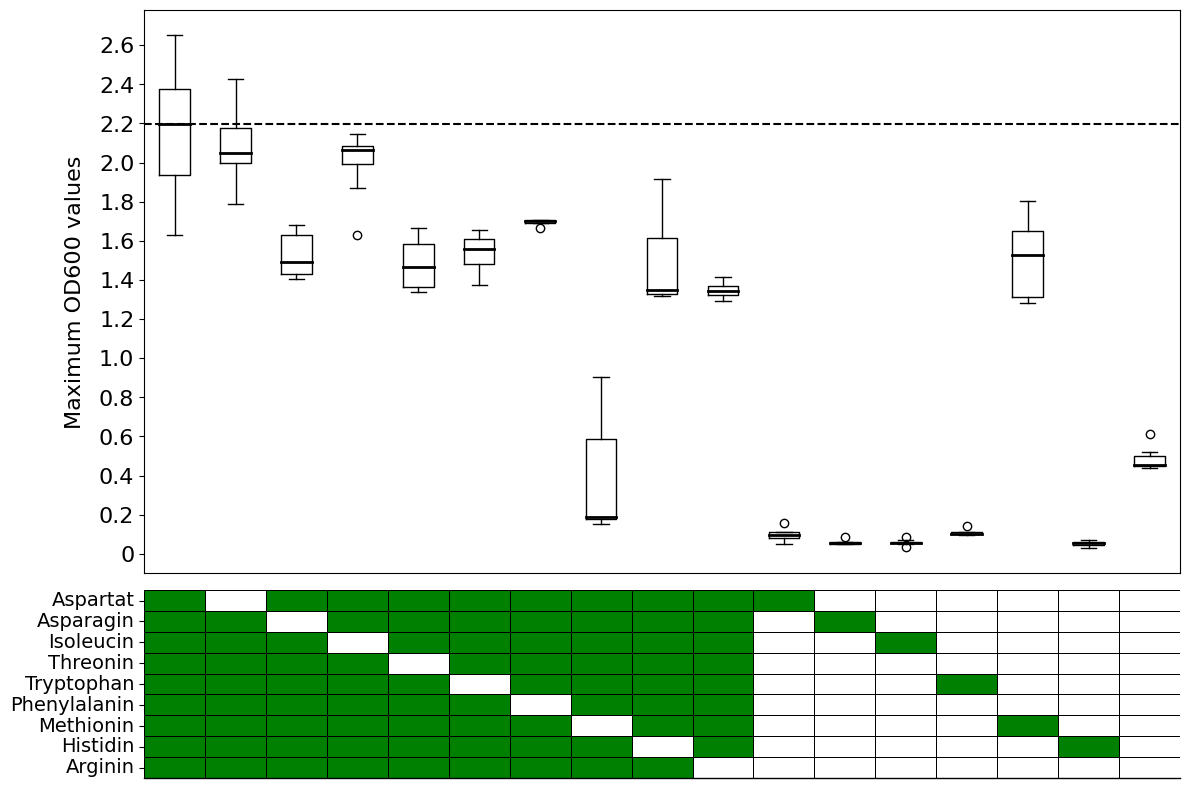

In [137]:
data_dict = {}
for col in df.columns:
    data_dict[col] = max_od_per_media[col]
    
xticks = [x+0.5 for x in range(len(data_dict.keys()))]
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 1, height_ratios=[3, 1])  # Boxplot above (1) and heatmap below (3)

ax1 = fig.add_subplot(gs[0])
boxplot_data = list(data_dict.values())

box = ax1.boxplot(boxplot_data, positions=xticks)
for median in box['medians']:
    median.set(color='black', linewidth=2)  # Change median color to red
    
ax1.set_title("")
ax1.set_xlabel("")
ax1.set_ylabel("Maximum OD600 values", fontsize=16, labelpad=10)
ax1.set_yticks(ticks=[0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0], labels=[0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0], fontsize=16)
ax1.tick_params(axis="x", which="both", bottom=False, labelbottom=False) 
ax1.hlines(np.median(data_dict["M2"]), xmin=0, xmax=44, color="black", linestyle="--")
ax2 = fig.add_subplot(gs[1], sharex=ax1)
colormap = ListedColormap(['white', 'green'])
sns.heatmap(df, cmap=colormap, cbar=False, linewidths=0.5, annot=False, ax=ax2, linecolor="black")
ax2.tick_params(axis="x", which="both", bottom=False, labelbottom=False) 
ax2.spines['bottom'].set_visible(True) 
ax2.tick_params(axis="y", labelsize=14)
ax2.spines['bottom'].set_linewidth(1)
ax2.spines['bottom'].set_color('black')
plt.tight_layout()
plt.savefig("../results/figures/amino_acids_combined_max_ods.png", dpi=300)

In [40]:
#without_methionine = all_od_data_dict["24_11_29_l2"]["AEP_0"]
#with_methionine = all_od_data_dict["24_11_29_l2"]["AEP_1"]

od_data = transform_od_data_dict(all_od_data_dict["24_11_29_l2"])
od_data = apply_savgol_filter_on_data_dict(od_data)
log_data_dict = transform_data_dict_to_log10(od_data)

[+] Starting to transform OD data dictionary
	[*] Working with: AEP_0
	[*] Working with: AEP_1
	[*] Working with: oli_0
	[*] Working with: oli_1
	[*] Working with: car_0
	[*] Working with: car_1
[+] DONE
[+] Trying to apply savgol filter to dataframe ...
	[*] Adjusting Index DataFrame: AEP_0
	[*] Replacing NaN values with -2.0
	[*] Adjusting Index DataFrame: AEP_1
	[*] Replacing NaN values with -2.0
	[*] Adjusting Index DataFrame: oli_0
	[*] Replacing NaN values with -2.0
	[*] Adjusting Index DataFrame: oli_1
	[*] Replacing NaN values with -2.0
	[*] Adjusting Index DataFrame: car_0
	[*] Replacing NaN values with -2.0
	[*] Adjusting Index DataFrame: car_1
	[*] Replacing NaN values with -2.0
[+] DONE
[+] Trying to transform dataframe ...
[+] DONE


In [41]:
for col in od_data["AEP_0"].columns:
    min_value = od_data["AEP_0"][col].min()
    od_data["AEP_0"][col] = od_data["AEP_0"][col] - min_value
    
for col in od_data["car_0"].columns:
    min_value = od_data["car_0"][col].min()
    od_data["car_0"][col] = od_data["car_0"][col] - min_value
    
for col in od_data["AEP_1"].columns:
    min_value = od_data["AEP_1"][col].min()
    od_data["AEP_1"][col] = od_data["AEP_1"][col] - min_value
    
for col in od_data["car_1"].columns:
    min_value = od_data["car_1"][col].min()
    od_data["car_1"][col] = od_data["car_1"][col] - min_value

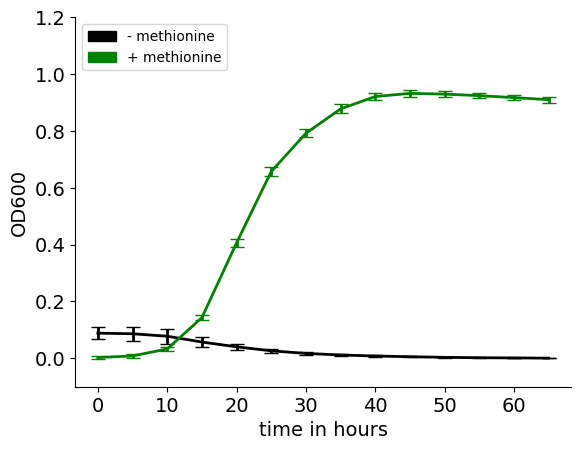

In [47]:
without_methionine_means = od_data["AEP_0"].mean(axis=1)
without_methionine_stds = od_data["AEP_0"].std(axis=1)

with_methionine_means = od_data["AEP_1"].mean(axis=1)
with_methionine_stds = od_data["AEP_1"].std(axis=1)

bar1 = plt.errorbar((np.array(list(range(len(without_methionine_means))[::30]))*10)/60, 
                    without_methionine_means[::30], yerr=without_methionine_stds[::30],
                    color="black", capsize=5, lw=2)
bar2 = plt.errorbar((np.array(list(range(len(without_methionine_means))[::30]))*10)/60, 
                    with_methionine_means[::30], yerr=with_methionine_stds[::30],
                    color="green", capsize=5, lw=2)
ax = plt.gca()
ax.spines['top'].set_visible(False)  
ax.spines['right'].set_visible(False)

patch1 = mpatches.Patch(color='black', label='- methionine')
patch2 = mpatches.Patch(color='green', label='+ methionine')

plt.legend(handles=[patch1, patch2], loc='upper left')
plt.xlabel("time in hours", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-0.1,1.2)

plt.ylabel("OD600", fontsize=14)
plt.savefig("../results/figures/washing/aep_with_without_met.svg")

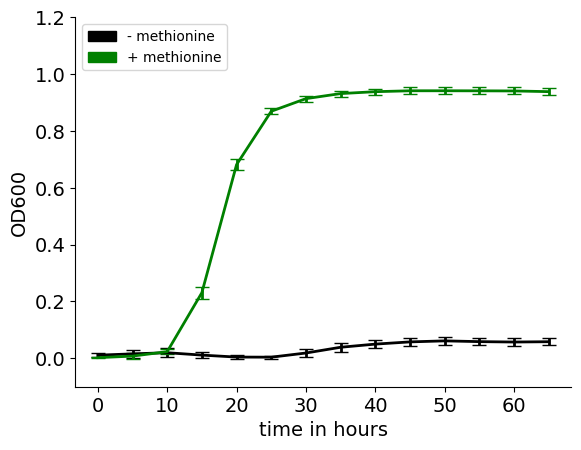

In [46]:
without_methionine_means = od_data["car_0"].mean(axis=1)
without_methionine_stds = od_data["car_0"].std(axis=1)

with_methionine_means = od_data["car_1"].mean(axis=1)
with_methionine_stds = od_data["car_1"].std(axis=1)

bar1 = plt.errorbar((np.array(list(range(len(without_methionine_means))[::30]))*10)/60, 
                    without_methionine_means[::30], yerr=without_methionine_stds[::30],
                    color="black", capsize=5, lw=2)
bar2 = plt.errorbar((np.array(list(range(len(without_methionine_means))[::30]))*10)/60, 
                    with_methionine_means[::30], yerr=with_methionine_stds[::30],
                    color="green", capsize=5, lw=2)
ax = plt.gca()
ax.spines['top'].set_visible(False)  
ax.spines['right'].set_visible(False)

patch1 = mpatches.Patch(color='black', label='- methionine')
patch2 = mpatches.Patch(color='green', label='+ methionine')

plt.legend(handles=[patch1, patch2], loc='upper left')
plt.xlabel("time in hours", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-0.1,1.2)

plt.ylabel("OD600", fontsize=14)
plt.savefig("../results/figures/washing/car_with_without_met.svg")

In [48]:
od_data = transform_od_data_dict(all_od_data_dict["24_11_29_l1"])
od_data = apply_savgol_filter_on_data_dict(od_data)
log_data_dict = transform_data_dict_to_log10(od_data)

[+] Starting to transform OD data dictionary
	[*] Working with: AEP_0
	[*] Working with: AEP_1
	[*] Working with: vul_0
	[*] Working with: vul_1
	[*] Working with: vir_0
	[*] Working with: vir_1
[+] DONE
[+] Trying to apply savgol filter to dataframe ...
	[*] Adjusting Index DataFrame: AEP_0
	[*] Replacing NaN values with -2.0
	[*] Adjusting Index DataFrame: AEP_1
	[*] Replacing NaN values with -2.0
	[*] Adjusting Index DataFrame: vul_0
	[*] Replacing NaN values with -2.0
	[*] Adjusting Index DataFrame: vul_1
	[*] Replacing NaN values with -2.0
	[*] Adjusting Index DataFrame: vir_0
	[*] Replacing NaN values with -2.0
	[*] Adjusting Index DataFrame: vir_1
	[*] Replacing NaN values with -2.0
[+] DONE
[+] Trying to transform dataframe ...
[+] DONE


In [39]:
for col in od_data["AEP_0"].columns:
    min_value = od_data["AEP_0"][col].min()
    od_data["AEP_0"][col] = od_data["AEP_0"][col] - min_value
    
for col in od_data["vul_0"].columns:
    min_value = od_data["vul_0"][col].min()
    od_data["vul_0"][col] = od_data["vul_0"][col] - min_value

for col in od_data["vir_0"].columns:
    min_value = od_data["vir_0"][col].min()
    od_data["vir_0"][col] = od_data["vir_0"][col] - min_value
    
for col in od_data["AEP_1"].columns:
    min_value = od_data["AEP_1"][col].min()
    od_data["AEP_1"][col] = od_data["AEP_1"][col] - min_value
    
for col in od_data["vul_1"].columns:
    min_value = od_data["vul_1"][col].min()
    od_data["vul_1"][col] = od_data["vul_1"][col] - min_value
    
for col in od_data["vir_1"].columns:
    min_value = od_data["vir_1"][col].min()
    od_data["vir_1"][col] = od_data["vir_1"][col] - min_value

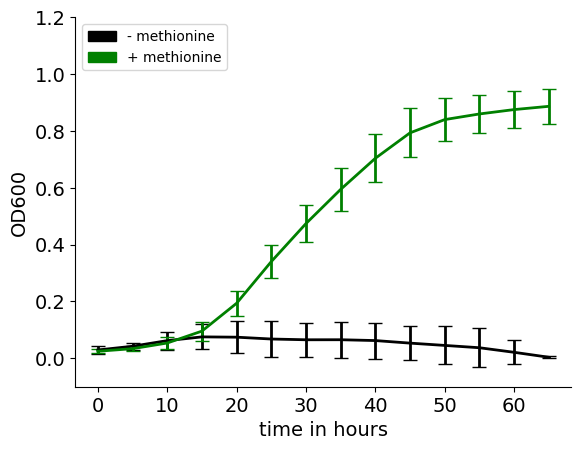

In [50]:
without_methionine_means = od_data["AEP_0"].mean(axis=1)
without_methionine_stds = od_data["AEP_0"].std(axis=1)

with_methionine_means = od_data["AEP_1"].mean(axis=1)
with_methionine_stds = od_data["AEP_1"].std(axis=1)

bar1 = plt.errorbar((np.array(list(range(len(without_methionine_means))[::30]))*10)/60, 
                    without_methionine_means[::30], yerr=without_methionine_stds[::30],
                    color="black", capsize=5, lw=2)
bar2 = plt.errorbar((np.array(list(range(len(without_methionine_means))[::30]))*10)/60, 
                    with_methionine_means[::30], yerr=with_methionine_stds[::30],
                    color="green", capsize=5, lw=2)
ax = plt.gca()
ax.spines['top'].set_visible(False)  
ax.spines['right'].set_visible(False)

patch1 = mpatches.Patch(color='black', label='- methionine')
patch2 = mpatches.Patch(color='green', label='+ methionine')

plt.legend(handles=[patch1, patch2], loc='upper left')
plt.xlabel("time in hours", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-0.1,1.2)

plt.ylabel("OD600", fontsize=14)
plt.savefig("../results/figures/washing/aep_with_without_met_2.svg")

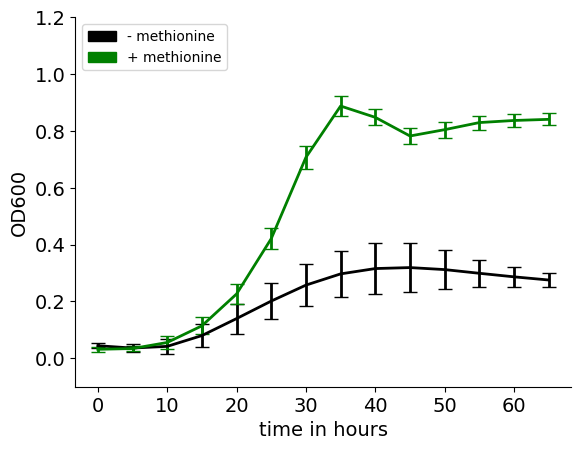

In [51]:
without_methionine_means = od_data["vul_0"].mean(axis=1)
without_methionine_stds = od_data["vul_0"].std(axis=1)

with_methionine_means = od_data["vul_1"].mean(axis=1)
with_methionine_stds = od_data["vul_1"].std(axis=1)

bar1 = plt.errorbar((np.array(list(range(len(without_methionine_means))[::30]))*10)/60, 
                    without_methionine_means[::30], yerr=without_methionine_stds[::30],
                    color="black", capsize=5, lw=2)
bar2 = plt.errorbar((np.array(list(range(len(without_methionine_means))[::30]))*10)/60, 
                    with_methionine_means[::30], yerr=with_methionine_stds[::30],
                    color="green", capsize=5, lw=2)
ax = plt.gca()
ax.spines['top'].set_visible(False)  
ax.spines['right'].set_visible(False)

patch1 = mpatches.Patch(color='black', label='- methionine')
patch2 = mpatches.Patch(color='green', label='+ methionine')

plt.legend(handles=[patch1, patch2], loc='upper left')
plt.xlabel("time in hours", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-0.1,1.2)

plt.ylabel("OD600", fontsize=14)
plt.savefig("../results/figures/washing/vul_with_without_met_2.svg")

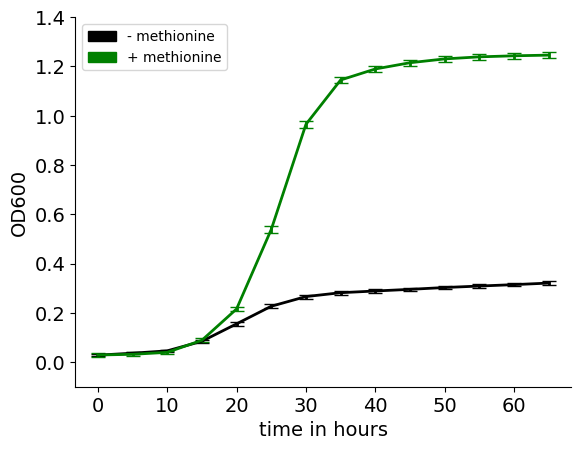

In [53]:
without_methionine_means = od_data["vir_0"].mean(axis=1)
without_methionine_stds = od_data["vir_0"].std(axis=1)

with_methionine_means = od_data["vir_1"].mean(axis=1)
with_methionine_stds = od_data["vir_1"].std(axis=1)

bar1 = plt.errorbar((np.array(list(range(len(without_methionine_means))[::30]))*10)/60, 
                    without_methionine_means[::30], yerr=without_methionine_stds[::30],
                    color="black", capsize=5, lw=2)
bar2 = plt.errorbar((np.array(list(range(len(without_methionine_means))[::30]))*10)/60, 
                    with_methionine_means[::30], yerr=with_methionine_stds[::30],
                    color="green", capsize=5, lw=2)
ax = plt.gca()
ax.spines['top'].set_visible(False)  
ax.spines['right'].set_visible(False)

patch1 = mpatches.Patch(color='black', label='- methionine')
patch2 = mpatches.Patch(color='green', label='+ methionine')

plt.legend(handles=[patch1, patch2], loc='upper left')
plt.xlabel("time in hours", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-0.1,1.4)

plt.ylabel("OD600", fontsize=14)
plt.savefig("../results/figures/washing/vir_with_without_met_2.svg")